Models like logistic regression or Naive Bayes algorithm, predict the probabilities of observing some outcomes. In standard binary regression scenario the models give you probability of observing the "success" category. In multinomial case, the models return probabilities of observing each of the outcomes. Log probabilities are simply natural logarithms of the predicted probabilities

LOADING THE DATA
----------

In [37]:
import os
os.getcwd()
os.chdir('/home/a4ankan/aMAZON fINAL WORK/amazon fine food')
os.getcwd()

'/home/a4ankan/aMAZON fINAL WORK/amazon fine food'

In [38]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import datetime



# it connects my code with the sql database
con = sqlite3.connect('database.sqlite') 



#Writting a query; 'con' is the link
# Here, I am saying that 'slelct (*) from reviews which are not equal to 3'.
#Just take the reviews which are 1,2,4 or 5.



filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) #filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3





# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return -1
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
filtered_data.sort_values('Time',inplace=True) 

print(filtered_data.shape) #The score coloumn becomesb positive / negative
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


Data Cleansing : deduplication
------------

In [39]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

(364173, 10)


69.25890143662969

In [40]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)



display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [41]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


 1    307061
-1     57110
Name: Score, dtype: int64

In [42]:
filtered_data[['Score','Text', 'Time']].head()

,Score,Text,Time
138706,1,this witty little book makes my son laugh at l...,939340800
138683,1,I can remember seeing the show when it aired o...,940809600
417839,1,Beetlejuice is a well written movie ..... ever...,944092800
417859,1,"A twist of rumplestiskin captured on film, sta...",944438400
212472,1,"A twist of rumplestiskin captured on film, sta...",944438400


How to convert Text to Vector?? Text Preprocessing: Stemming, stop-word removal and Lemmatization.
-------------


In [43]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

1
Summary:  A young boy describes the usefulness of chicken soup with rice for each month of the year.<br /><br />Evaluation:  With Sendak's creative repetitious and rhythmic words, children will enjoy and learn to read the story of a boy who loves chicken soup with rice!  Through Sendak's catchy story, children will also learn the months of the year, as well as what seasons go with what month! They learn to identify ice-skating and snowmen in the winter; strong wind in March; birds and flowers in the spring; swimming and hot temperatures in the summer; and finally different holidays throughout the year. Such as Halloween in October, and Christmas in December.<br /><br />Sendak's simple three colored crayon-like drawings are a perfect addition to his educational and entertaining story.<br /><br />A great activity that you can do with this book is to have children draw their own illustrations for each month of the year.  Afterwards you can bind the pages together so the children can cre

In [44]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'into', 'are', 'off', 'ain', 'over', 'as', 'there', 'needn', 'during', 'wouldn', 'has', 'o', "should've", 'myself', 'when', "couldn't", "you're", 'all', 'until', 'mustn', "isn't", 'yourself', 'which', 'his', "needn't", "aren't", 'because', 'here', "didn't", 'own', 'most', "you've", 'for', 's', "don't", 'be', 'against', 'wasn', "shan't", 'her', 'to', 'any', 'both', 'and', 'at', 'we', 'these', "hasn't", 'they', 'can', 'itself', 'with', 'same', 'couldn', 'each', 'ma', "you'll", "mustn't", 'don', 've', 'again', 'your', 'or', 'shan', 'doing', "won't", "it's", 'whom', 'above', 'i', 'm', 'between', 'have', 'having', 'other', 'themselves', 'you', 'its', 'hers', 'then', 'theirs', 'on', 'those', 't', "wouldn't", 'being', 'in', 'me', 'before', 'by', 'had', 'very', 'who', 'such', 'hasn', 'were', 'no', 'an', 'will', 'if', 'just', 'yours', 'he', 'more', 'now', 'mightn', 'why', 'than', 'aren', 'my', 're', 'about', 'what', 'not', 'where', 'while', 'himself', "she's", 'y', 'did', 'isn', "weren't", 'is

In [45]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
    

In [46]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final.sort_values('Time',inplace=True) 

In [47]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Summary'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
    

In [48]:
final['New'] = final['Summary'] + final['CleanedText']

In [49]:
final['New']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['New']=final['New'].str.decode("utf-8")
final.sort_values('Time',inplace=True)

In [50]:

# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [51]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,New
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [52]:
type(final)

pandas.core.frame.DataFrame

In [53]:
X = final['CleanedText']
X.head()


138706    witti littl book make son laugh loud recit car...
138683    rememb see show air televis year ago child sis...
417839    beetlejuic well written movi everyth excel act...
346055    twist rumplestiskin captur film star michael k...
417838    beetlejuic excel funni movi keaton hilari wack...
Name: CleanedText, dtype: object

In [54]:
Y = final['Score']
Y.head(5)

138706    1
138683    1
417839    1
346055    1
417838    1
Name: Score, dtype: int64

In [55]:
Y.shape

(364171,)

In [56]:
from sklearn import cross_validation
warnings.filterwarnings("ignore")

In [57]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)

In [58]:
print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (254919,)
Test Data Size:  (109252,)


In [59]:
print("Train Data Size: ",Y_train.shape)
print("Test Data Size: ",Y_test.shape)

Train Data Size:  (254919,)
Test Data Size:  (109252,)


# Bernoulli Naive Bayes:

Bag Of Words (BoW) :
-----------

Bag of Words constructs a dictionary of all the words in the document. A corpous is defined as a set of documents/reviews.
It converts all the words in the document into a vector each word having a different dimension. Each cell in the vector corresponds to the no of times a word occurs in the document.
 Similar texts result in closer distances between two vectors. Although BoW has its own limitations.


In [89]:
#BoW

count_vect = CountVectorizer(binary = True) #in scikit-learn
X_train_bow = count_vect.fit_transform(X_train) #
X_test_bow = count_vect.transform(X_test)#
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (254919, 59777)
the number of unique words  59777


In [90]:
import warnings
warnings.filterwarnings("ignore")

# Standardizing the data with mean = 0 and std.dev = 1
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean= False).fit_transform(X_train_bow)
X_train_bow = standardized_data
print(X_train_bow.shape)



(254919, 59777)


In [91]:
standardized_data = StandardScaler(with_mean= False).fit_transform(X_test_bow)
X_test_bow = standardized_data
print(X_test_bow.shape)

(109252, 59777)


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation


In [93]:
print("Train Data Size: ",X_train_bow.shape)
print("Test Data Size: ",X_test_bow.shape)

Train Data Size:  (254919, 59777)
Test Data Size:  (109252, 59777)


In [94]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train_bow):
    print(X_train_bow[train].shape, X_train_bow[cv].shape)


(23179, 59777) (23174, 59777)
(46353, 59777) (23174, 59777)
(69527, 59777) (23174, 59777)
(92701, 59777) (23174, 59777)
(115875, 59777) (23174, 59777)
(139049, 59777) (23174, 59777)
(162223, 59777) (23174, 59777)
(185397, 59777) (23174, 59777)
(208571, 59777) (23174, 59777)
(231745, 59777) (23174, 59777)


In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB
from datetime import datetime

Finding optimal alpha for laplace smoothing..... 
---------------

In [96]:

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
start = datetime.now()
bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv, scoring = 'accuracy',verbose=1)
gsv.fit(X_train_bow,Y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))



print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best HyperParameter:  {'alpha': 0.01}
Best Accuracy: 88.87%
------------------------------------------------------------------------
Time taken to run this cell :
 0:00:31.074873
------------------------------------------------------------------------


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   30.9s finished


In [97]:

start = datetime.now()
bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv, scoring = 'f1',verbose=1)
gsv.fit(X_train_bow,Y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))



print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best HyperParameter:  {'alpha': 0.01}
Best Accuracy: 93.41%
------------------------------------------------------------------------
Time taken to run this cell :
 0:00:31.421965
------------------------------------------------------------------------


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   31.3s finished


In [98]:

start = datetime.now()
bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv, scoring = 'roc_auc',verbose=1)
gsv.fit(X_train_bow,Y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))



print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best HyperParameter:  {'alpha': 0.1}
Best Accuracy: 91.58%
------------------------------------------------------------------------
Time taken to run this cell :
 0:00:32.258053
------------------------------------------------------------------------


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   32.1s finished


In [80]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

Accuracy on test set: 89.286%
Macro F1-Score on test set: 0.794
Micro F1-Score on test set: 0.893
Weighted F1-Score on test set: 0.892
Macro roc_auc Score on test set: 0.791
Micro roc_auc Score on test set: 0.791
Weighted roc_auc Score on test set: 0.791
Precision on test set: 0.935
Recall on test set: 0.939
Error : 10.714%
Precision recall report :
              precision    recall  f1-score   support

         -1       0.66      0.64      0.65     17034
          1       0.93      0.94      0.94     92218

avg / total       0.89      0.89      0.89    109252

TPR is 0.9388297295538832
TNR is 0.6440061054361864
FPR is 0.35599389456381353
FNR is 0.06117027044611681

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:49.608419
------------------------------------------------------------------------


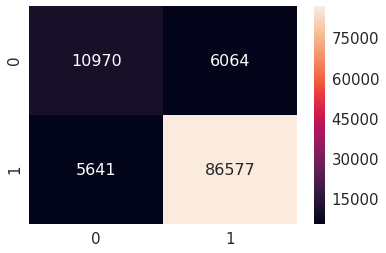

In [99]:
Nb = BernoulliNB(alpha= 0.01)
clf = Nb.fit(X_train_bow, Y_train)
Y_pred = Nb.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 89.258%
Macro F1-Score on test set: 0.796
Micro F1-Score on test set: 0.893
Weighted F1-Score on test set: 0.892
Macro roc_auc Score on test set: 0.795
Micro roc_auc Score on test set: 0.795
Weighted roc_auc Score on test set: 0.795
Precision on test set: 0.936
Recall on test set: 0.937
Error : 10.742%
Precision recall report :
              precision    recall  f1-score   support

         -1       0.66      0.65      0.65     17034
          1       0.94      0.94      0.94     92218

avg / total       0.89      0.89      0.89    109252

TPR is 0.9367260187815828
TNR is 0.6535752025361042
FPR is 0.34642479746389576
FNR is 0.06327398121841724

------------------------------------------------------------------------
Time taken to run this cell :
 0:00:59.151384
------------------------------------------------------------------------


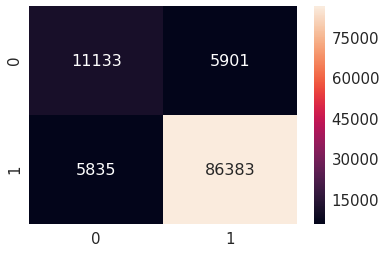

In [100]:
Nb = BernoulliNB(alpha= 0.1)
clf_roc = Nb.fit(X_train_bow, Y_train)
Y_pred = Nb.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Top Positive & Negative Words:
-----------

In [102]:
all_feat = count_vect.get_feature_names()

In [103]:
clf.class_count_

array([ 40076., 214843.])

In [104]:
clf.feature_count_

array([[ 0.,  1.,  0., ...,  1.,  0.,  0.],
       [ 2., 11.,  1., ...,  0.,  1.,  1.]])

In [105]:
clf.feature_log_prob_

array([[-15.20370362, -10.5885831 , -15.20370362, ..., -10.5885831 ,
        -15.20370362, -15.20370362],
       [-11.57952818,  -9.87885895, -12.26771257, ..., -16.88283309,
        -12.26771257, -12.26771257]])

In [106]:
feat = pd.DataFrame(clf.feature_log_prob_,columns=all_feat)

In [107]:
feat.head()

,aa,aaa,aaaa,aaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaagghh,aaaaaaah,aaaaaaahhhhhh,aaaaaaarrrrrggghhh,aaaaaah,...,zzzzs,zzzzzs,zzzzzz,zzzzzzz,zzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,çay,çelem,île,îts
0,-15.203704,-10.588583,-15.203704,-10.588583,-15.203704,-15.203704,-15.203704,-15.203704,-10.588583,-15.203704,...,-15.203704,-15.203704,-15.203704,-10.588583,-15.203704,-15.203704,-15.203704,-10.588583,-15.203704,-15.203704
1,-11.579528,-9.878859,-12.267713,-12.267713,-12.267713,-12.267713,-12.267713,-12.267713,-16.882833,-12.267713,...,-12.267713,-12.267713,-12.267713,-16.882833,-12.267713,-12.267713,-12.267713,-16.882833,-12.267713,-12.267713


In [108]:
feat = feat.T
feat.shape

(59777, 2)

In [109]:
feat.head(5)

,0,1
aa,-15.203704,-11.579528
aaa,-10.588583,-9.878859
aaaa,-15.203704,-12.267713
aaaaa,-10.588583,-12.267713
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,-15.203704,-12.267713


In [110]:
top_pos_word = feat[1].sort_values(ascending = False)[0:30]

In [111]:
df = pd.DataFrame(top_pos_word )
df



,1
like,-1.177257
tast,-1.202049
love,-1.262482
good,-1.267066
great,-1.294151
flavor,-1.425940
one,-1.473709
use,-1.474339
tri,-1.530713
product,-1.538878


In [113]:
top_neg_word = feat[0].sort_values(ascending = False)[0:30]

In [114]:
df = pd.DataFrame(top_neg_word)
df

,0
tast,-0.986468
like,-1.007635
product,-1.179066
one,-1.364769
would,-1.415358
tri,-1.468210
flavor,-1.552595
good,-1.564571
buy,-1.602252
get,-1.656202


# tf & idf: Term frequency & Inverse document frequency


In [116]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), binary = True)
X_train_tf = tf_idf_vect.fit_transform(X_train.values)
X_test_tf = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_tf))
print("the shape of out text TFIDF vectorizer ",X_train_tf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (254919, 2329461)
the number of unique words including both unigrams and bigrams  2329461


Finding optimal alpha for laplace smoothing..... 
---------------

In [117]:
standardized_data = StandardScaler(with_mean= False).fit_transform(X_train_tf)
X_train_tf = standardized_data
print(X_train_tf.shape)

(254919, 2329461)


In [118]:
standardized_data = StandardScaler(with_mean= False).fit_transform(X_test_tf)
X_test_tf = standardized_data
print(X_test_tf.shape)

(109252, 2329461)


In [119]:
print("Train Data Size: ",X_train_tf.shape)
print("Test Data Size: ",X_test_tf.shape)

Train Data Size:  (254919, 2329461)
Test Data Size:  (109252, 2329461)


In [120]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train_tf):
    print(X_train_tf[train].shape, X_train_tf[cv].shape)


(23179, 2329461) (23174, 2329461)
(46353, 2329461) (23174, 2329461)
(69527, 2329461) (23174, 2329461)
(92701, 2329461) (23174, 2329461)
(115875, 2329461) (23174, 2329461)
(139049, 2329461) (23174, 2329461)
(162223, 2329461) (23174, 2329461)
(185397, 2329461) (23174, 2329461)
(208571, 2329461) (23174, 2329461)
(231745, 2329461) (23174, 2329461)


In [121]:
start = datetime.now()
bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv, scoring = 'accuracy',verbose=1)
gsv.fit(X_train_tf,Y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))



print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.0min finished


Best HyperParameter:  {'alpha': 0.005}
Best Accuracy: 89.41%
------------------------------------------------------------------------
Time taken to run this cell :
 0:03:00.519507
------------------------------------------------------------------------


In [122]:
start = datetime.now()
bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv, scoring = 'f1',verbose=1)
gsv.fit(X_train_tf,Y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))



print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.0min finished


Best HyperParameter:  {'alpha': 0.001}
Best Accuracy: 93.86%
------------------------------------------------------------------------
Time taken to run this cell :
 0:02:57.967025
------------------------------------------------------------------------


In [123]:
start = datetime.now()
bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv, scoring = 'roc_auc',verbose=1)
gsv.fit(X_train_tf,Y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))



print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.1min finished


Best HyperParameter:  {'alpha': 0.01}
Best Accuracy: 90.65%
------------------------------------------------------------------------
Time taken to run this cell :
 0:03:04.550022
------------------------------------------------------------------------


Accuracy on test set: 90.608%
Macro F1-Score on test set: 0.781
Micro F1-Score on test set: 0.906
Weighted F1-Score on test set: 0.895
Macro roc_auc Score on test set: 0.732
Micro roc_auc Score on test set: 0.732
Weighted roc_auc Score on test set: 0.732
Precision on test set: 0.911
Recall on test set: 0.985
Error : 9.392%
Precision recall report :
              precision    recall  f1-score   support

         -1       0.85      0.48      0.61     17034
          1       0.91      0.98      0.95     92218

avg / total       0.90      0.91      0.89    109252

TPR is 0.9847643627057624
TNR is 0.48009862627685806
FPR is 0.5199013737231419
FNR is 0.015235637294237568

------------------------------------------------------------------------
Time taken to run this cell :
 0:12:13.529254
------------------------------------------------------------------------


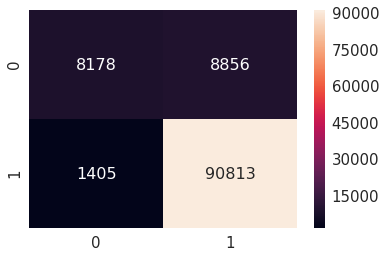

In [127]:
Nb = BernoulliNB(alpha= 0.005)
clf_acc = Nb.fit(X_train_tf, Y_train)
Y_pred = Nb.predict(X_test_tf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 89.764%
Macro F1-Score on test set: 0.749
Micro F1-Score on test set: 0.898
Weighted F1-Score on test set: 0.882
Macro roc_auc Score on test set: 0.699
Micro roc_auc Score on test set: 0.699
Weighted roc_auc Score on test set: 0.699
Precision on test set: 0.901
Recall on test set: 0.988
Error : 10.236%
Precision recall report :
              precision    recall  f1-score   support

         -1       0.86      0.41      0.56     17034
          1       0.90      0.99      0.94     92218

avg / total       0.89      0.90      0.88    109252

TPR is 0.9875295495456419
TNR is 0.41100152635904663
FPR is 0.5889984736409534
FNR is 0.012470450454358151

------------------------------------------------------------------------
Time taken to run this cell :
 0:12:33.513061
------------------------------------------------------------------------


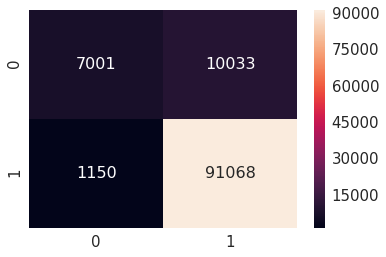

In [128]:
Nb = BernoulliNB(alpha= 0.001)
clf_roc = Nb.fit(X_train_tf, Y_train)
Y_pred = Nb.predict(X_test_tf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 91.016%
Macro F1-Score on test set: 0.795
Micro F1-Score on test set: 0.910
Weighted F1-Score on test set: 0.901
Macro roc_auc Score on test set: 0.749
Micro roc_auc Score on test set: 0.749
Weighted roc_auc Score on test set: 0.749
Precision on test set: 0.917
Recall on test set: 0.983
Error : 8.984%
Precision recall report :
              precision    recall  f1-score   support

         -1       0.85      0.52      0.64     17034
          1       0.92      0.98      0.95     92218

avg / total       0.91      0.91      0.90    109252

TPR is 0.983116094471795
TNR is 0.5152048843489492
FPR is 0.4847951156510508
FNR is 0.016883905528204905

------------------------------------------------------------------------
Time taken to run this cell :
 0:12:41.579904
------------------------------------------------------------------------


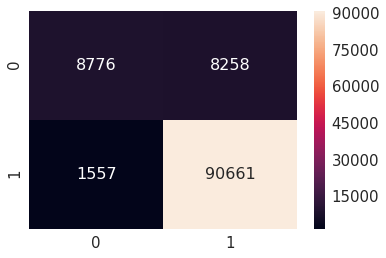

In [129]:
Nb = BernoulliNB(alpha= 0.01)
clf_f1 = Nb.fit(X_train_tf, Y_train)
Y_pred = Nb.predict(X_test_tf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Top Positive & Negative Words:
-----------

In [130]:
clf_acc.class_count_


array([ 40076., 214843.])

In [131]:
clf_acc.feature_log_prob_

array([[-15.89685055, -15.89685055, -15.89685055, ..., -15.89685055,
        -15.89685055, -15.89685055],
       [-11.58201879, -12.27267531, -12.27267531, ..., -12.27267531,
        -12.27267531, -12.27267531]])

In [139]:
top_pos_word = feat[1].sort_values(ascending = False)[0:25]

In [140]:
df = pd.DataFrame(top_pos_word)
df

,1
like,-1.177257
tast,-1.202049
love,-1.262482
good,-1.267066
great,-1.294151
flavor,-1.425940
one,-1.473709
use,-1.474339
tri,-1.530713
product,-1.538878


In [141]:
top_neg_word = feat[0].sort_values(ascending = False)[0:25]

In [142]:
df = pd.DataFrame(top_neg_word)
df

,0
tast,-0.986468
like,-1.007635
product,-1.179066
one,-1.364769
would,-1.415358
tri,-1.468210
flavor,-1.552595
good,-1.564571
buy,-1.602252
get,-1.656202


# Multinomial naive Bayes:

BAg of Words:
------------

In [143]:
#BoW

count_vect = CountVectorizer() #in scikit-learn
X_train_bow = count_vect.fit_transform(X_train) #
X_test_bow = count_vect.transform(X_test)#
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (254919, 59777)
the number of unique words  59777


In [144]:

standardized_data = StandardScaler(with_mean= False).fit_transform(X_train_bow)
X_train_bow = standardized_data
print(X_train_bow.shape)


standardized_data = StandardScaler(with_mean= False).fit_transform(X_test_bow)
X_test_bow = standardized_data
print(X_test_bow.shape)

(254919, 59777)
(109252, 59777)


In [145]:
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train_bow):
    print(X_train_bow[train].shape, X_train_bow[cv].shape)

(23179, 59777) (23174, 59777)
(46353, 59777) (23174, 59777)
(69527, 59777) (23174, 59777)
(92701, 59777) (23174, 59777)
(115875, 59777) (23174, 59777)
(139049, 59777) (23174, 59777)
(162223, 59777) (23174, 59777)
(185397, 59777) (23174, 59777)
(208571, 59777) (23174, 59777)
(231745, 59777) (23174, 59777)


In [148]:

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(mnb,param_grid,cv=tscv, scoring = 'accuracy',verbose=1)
gsv.fit(X_train_bow,Y_train)
print("Best HyperParameter with Accuracy as the metric: ",gsv.best_params_)
print("Best Accuracy with Accuracy as the metric: %.2f%%"%(gsv.best_score_*100))

print("\n\n________________________________________________________________________\n\n")

param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv_f1 = GridSearchCV(mnb,param_grid,cv=tscv, scoring = 'f1',verbose=1)
gsv_f1.fit(X_train_bow,Y_train)
print("Best HyperParameter with f1 score as the metric: ",gsv_f1.best_params_)
print("Best Accuracy with f1 score as the metric: %.2f%%"%(gsv_f1.best_score_*100))

print('\n\n__________________________________________________________________________\n\n')


param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv_roc = GridSearchCV(mnb,param_grid,cv=tscv, scoring = "roc_auc",verbose=1)
gsv_roc.fit(X_train_bow,Y_train)
print("Best HyperParameter with auc score as the metric: ",gsv_roc.best_params_)
print("Best Accuracy with auc score as the metric: %.2f%%"%(gsv_roc.best_score_*100))



print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')



Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   18.8s finished


Best HyperParameter with Accuracy as the metric:  {'alpha': 1000}
Best Accuracy with Accuracy as the metric: 81.21%


________________________________________________________________________


Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   20.5s finished


Best HyperParameter with f1 score as the metric:  {'alpha': 1000}
Best Accuracy with f1 score as the metric: 89.37%


__________________________________________________________________________


Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best HyperParameter with auc score as the metric:  {'alpha': 10}
Best Accuracy with auc score as the metric: 73.87%
------------------------------------------------------------------------
Time taken to run this cell :
 4:47:45.511151
------------------------------------------------------------------------


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   22.6s finished


Accuracy on test set: 84.741%
Macro F1-Score on test set: 0.570
Micro F1-Score on test set: 0.847
Weighted F1-Score on test set: 0.808
Macro roc_auc Score on test set: 0.559
Micro roc_auc Score on test set: 0.559
Weighted roc_auc Score on test set: 0.559
Precision on test set: 0.860
Recall on test set: 0.978
Error : 15.259%
Precision recall report :
              precision    recall  f1-score   support

         -1       0.54      0.14      0.22     17034
          1       0.86      0.98      0.92     92218

avg / total       0.81      0.85      0.81    109252

TPR is 0.9779001930208853
TNR is 0.14095338734296115
FPR is 0.8590466126570389
FNR is 0.022099806979114706

------------------------------------------------------------------------
Time taken to run this cell :
 4:52:20.613757
------------------------------------------------------------------------
CPU times: user 393 ms, sys: 427 µs, total: 393 ms
Wall time: 389 ms


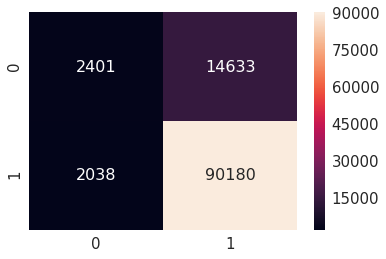

In [151]:

mnb = MultinomialNB(alpha = 1000)
clf = mnb.fit(X_train_bow, Y_train)
Y_pred = mnb.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy on test set: 82.716%
Macro F1-Score on test set: 0.721
Micro F1-Score on test set: 0.827
Weighted F1-Score on test set: 0.840
Macro roc_auc Score on test set: 0.766
Micro roc_auc Score on test set: 0.766
Weighted roc_auc Score on test set: 0.766
Precision on test set: 0.935
Recall on test set: 0.855
Error : 17.284%
Precision recall report :
              precision    recall  f1-score   support

         -1       0.46      0.68      0.55     17034
          1       0.93      0.85      0.89     92218

avg / total       0.86      0.83      0.84    109252

TPR is 0.8549523954108742
TNR is 0.6767054127040038
FPR is 0.32329458729599625
FNR is 0.14504760458912577

------------------------------------------------------------------------
Time taken to run this cell :
 4:53:19.125129
------------------------------------------------------------------------


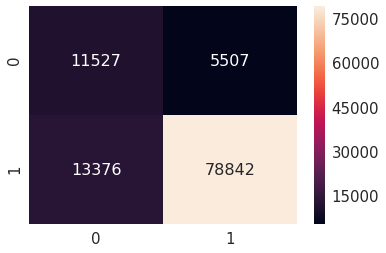

In [153]:
mnb = MultinomialNB(alpha = 10)
clf_1 = mnb.fit(X_train_bow, Y_train)
Y_pred = mnb.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Tf-idf:
------------

In [160]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train_tf = tf_idf_vect.fit_transform(X_train.values)
X_test_tf = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_tf))
print("the shape of out text TFIDF vectorizer ",X_train_tf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (254919, 2329461)
the number of unique words including both unigrams and bigrams  2329461


In [161]:
mnb = MultinomialNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(mnb,param_grid,cv=tscv, scoring = 'accuracy',verbose=1)
gsv.fit(X_train_tf,Y_train)
print("Best HyperParameter with Accuracy as the metric: ",gsv.best_params_)
print("Best Accuracy with Accuracy as the metric: %.2f%%"%(gsv.best_score_*100))

print("\n\n________________________________________________________________________\n\n")

param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv_f1 = GridSearchCV(mnb,param_grid,cv=tscv, scoring = 'f1',verbose=1)
gsv_f1.fit(X_train_tf,Y_train)
print("Best HyperParameter with f1 score as the metric: ",gsv_f1.best_params_)
print("Best Accuracy with f1 score as the metric: %.2f%%"%(gsv_f1.best_score_*100))

print('\n\n__________________________________________________________________________\n\n')


param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv_roc = GridSearchCV(mnb,param_grid,cv=tscv, scoring = "roc_auc",verbose=1)
gsv_roc.fit(X_train_tf,Y_train)
print("Best HyperParameter with auc score as the metric: ",gsv_roc.best_params_)
print("Best Accuracy with auc score as the metric: %.2f%%"%(gsv_roc.best_score_*100))



print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')



Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.3min finished


Best HyperParameter with Accuracy as the metric:  {'alpha': 0.01}
Best Accuracy with Accuracy as the metric: 89.08%


________________________________________________________________________


Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.4min finished


Best HyperParameter with f1 score as the metric:  {'alpha': 0.01}
Best Accuracy with f1 score as the metric: 93.56%


__________________________________________________________________________


Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.4min finished


Best HyperParameter with auc score as the metric:  {'alpha': 0.01}
Best Accuracy with auc score as the metric: 91.30%
------------------------------------------------------------------------
Time taken to run this cell :
 5:02:56.853641
------------------------------------------------------------------------


Accuracy on test set: 90.478%
Macro F1-Score on test set: 0.771
Micro F1-Score on test set: 0.905
Weighted F1-Score on test set: 0.891
Macro roc_auc Score on test set: 0.719
Micro roc_auc Score on test set: 0.719
Weighted roc_auc Score on test set: 0.719
Precision on test set: 0.907
Recall on test set: 0.989
Error : 9.522%
Precision recall report :
              precision    recall  f1-score   support

         -1       0.88      0.45      0.60     17034
          1       0.91      0.99      0.95     92218

avg / total       0.90      0.90      0.89    109252

TPR is 0.988787438461038
TNR is 0.44998238816484676
FPR is 0.5500176118351532
FNR is 0.011212561538962025

------------------------------------------------------------------------
Time taken to run this cell :
 5:02:57.732179
------------------------------------------------------------------------


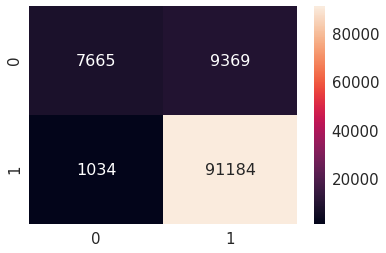

In [162]:
mnb = MultinomialNB(alpha = 0.01)
clf = mnb.fit(X_train_tf, Y_train)
Y_pred = mnb.predict(X_test_tf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100)) 
print("Macro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='macro')))
print("Micro F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='micro')))
print("Weighted F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Macro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='macro')))
print("Micro roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='micro')))
print("Weighted roc_auc Score on test set: %0.3f"%(roc_auc_score(Y_test, Y_pred, 
                                                              average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred)))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))
print("Precision recall report :\n",metrics.classification_report(Y_test, Y_pred))
CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


print('\n------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

In [176]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["S.R","Vec", "Alpha", "Micro f-1", "Weighted f-1", 'roc_auc']

x.add_row([(1),"BOW", 0.01,0.794,0.893,0.892])
x.add_row([(2),"TF-IDF", 0.01,0.910,0.901,0.749])


print(x.get_string(title = "Bernoulis' Naive Bayes"))

print("_______________________________________________________________________________________\n")
y = PrettyTable()

y.field_names =["S.R","Vec", "Alpha", "Micro f-1", "Weighted f-1", 'roc_auc']

y.add_row([(1),"BOW",  10**3,0.847,0.808,0.559])
y.add_row([(2),"TF-IDF",  0.01,0.905,0.891,0.719])




print(y.get_string(title = "Multi Nomial Naive bayes"))

+-----------------------------------------------------------+
|                   Bernoulis' Naive Bayes                  |
+-----+--------+-------+-----------+--------------+---------+
| S.R |  Vec   | Alpha | Micro f-1 | Weighted f-1 | roc_auc |
+-----+--------+-------+-----------+--------------+---------+
|  1  |  BOW   |  0.01 |   0.794   |    0.893     |  0.892  |
|  2  | TF-IDF |  0.01 |    0.91   |    0.901     |  0.749  |
+-----+--------+-------+-----------+--------------+---------+
_______________________________________________________________________________________

+-----------------------------------------------------------+
|                  Multi Nomial Naive bayes                 |
+-----+--------+-------+-----------+--------------+---------+
| S.R |  Vec   | Alpha | Micro f-1 | Weighted f-1 | roc_auc |
+-----+--------+-------+-----------+--------------+---------+
|  1  |  BOW   |  1000 |   0.847   |    0.808     |  0.559  |
|  2  | TF-IDF |  0.01 |   0.905   |    0.8